# Multiclass Classifier with SVM for Customer IT Support Ticket Dataset

## **Task Description**
In this task, you will create a multiclass classifier based on an SVM for the dataset ["Customer IT Support - Ticket Dataset"](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets). The dataset consists of 20,000 rows. Each record has the following structure (header):

subject, body, answer, type, queue, priority, language, tag_1, tag_2, tag_3, tag_4, tag_5, tag_6, tag_7, tag_8


For the task development, you will only use the columns `subject` and `body` (concatenated into a single message) as input information and the column `type` as the classification label.

---

## **1. Exploration**

1. Load the dataset (`dataset-tickets-multi-lang-4-20k.csv`) and visualize some rows to understand its structure and content.
2. Perform a descriptive analysis of the variables, for example:
   - Distribution of the `type` variable.
   - Length of the messages resulting from concatenating `subject` and `body`.
3. Comment on any relevant aspects or potential issues, such as missing data or inconsistencies.

---

## **2. Preprocessing**

1. Concatenate the columns `subject` and `body` to form the message.
2. Select a sample of **N = 1,000** rows from the full dataset. Keep **N** as a modifiable parameter.
3. Split the dataset into training and test sets, using **25%** of the data for testing.

---

## **3. String Kernel Implementation**

Implement a kernel that, for two strings, counts the number of common **trigrams** (substrings of length 3), as discussed in the theoretical class.

---

## **4. SVM Training**

Use the implemented kernel to train an **SVM** on the training set.

---

## **5. Model Evaluation and Analysis**

1. Calculate the classifier's accuracy on the test set.
2. Adjust the classifier parameters and discuss their effect on accuracy. Test different values of **N**.
3. Analyze some misclassified messages:
   - What characteristics do they present?
   - What aspects might have led to the misclassification?
4. Visualize the decision boundaries in a 2-dimensional space:
   - Apply a dimensionality reduction technique (e.g., **PCA** or **t-SNE**) to the feature vectors.
   - Generate a figure highlighting correctly and incorrectly classified messages.
5. **Multiclass SVM:** Investigate and describe which multiclass modality is used in your implementation ("**one-vs-all**," "**one-vs-one**," etc.).

---

## **6. Use of another model**

1. Use another classification method (e.g., **Random Forest**, **XGBoost**, etc.).
2. Compare its results with the SVM in terms of both **accuracy** and **execution time**.

---


## **1. Exploration**

Let's load the dataset and delete all columns that are not `subject`, `body` and `type`. We keep `language` because it's helpfull for elaborating text.

In [2]:
import matplotlib.pyplot as plt
import random
plt.style.use('dark_background')
import numpy as np
import pandas as pd

Set a seed for reproducibility of the experiments.

In [3]:
from sklearn.utils import check_random_state
seed = 43
np.random.seed(seed)
random.seed(seed)
pd.options.mode.chained_assignment = None
sklearn_random_state = check_random_state(seed)

In [4]:
features = ['subject', 'body', 'type', 'language'] # extract from the data

df = pd.read_csv('./data/dataset-tickets-multi-lang-4-20k.csv')
# delete the columns that are not needed
df = df.drop(df.columns.difference(features), axis=1)


Let's analyze the dataset.

In [5]:
df

,subject,body,type,language
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Incident,de
1,Customer Support Inquiry,Seeking information on digital strategies that...,Request,en
2,Data Analytics for Investment,I am contacting you to request information on ...,Request,en
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Incident,de
4,Security,"Dear Customer Support, I am reaching out to in...",Request,en
...,...,...,...,...
19995,Assistance Needed for IFTTT Docker Integration,I am facing integration problems with IFTTT Do...,Problem,en
19996,Bitten um Unterstützung bei der Integration,"Sehr geehrte Kundenservice, ich möchte die Int...",Change,de
19997,NaN,"Hello Customer Support, I am inquiring about t...",Request,en
19998,Hilfe bei digitalen Strategie-Problemen,Die Qualität unserer digitalen Strategie-Bearb...,Incident,de


In [6]:
print("General DataFrame Information:")
print(df.info())
print("\nDataFrame Shape:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Descriptive statistics for text columns
print("\nDescriptive Statistics for Text Columns:")
for col in df.columns.difference(['language']):
    print(f"\n--- Column: '{col}' ---")
    print(f"- Unique values: {df[col].nunique()}")
    print(f"- Missing values: {df[col].isnull().sum()}")

    # Text length analysis
    text_lengths = df[col].dropna().apply(lambda x: len(x.split()))
    print(f"- Average text length (in words): {text_lengths.mean():.2f}")
    print(f"- Maximum text length (in words): {text_lengths.max()}")
    print(f"- Minimum text length (in words): {text_lengths.min()}")


General DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   type      20000 non-null  object
 3   language  20000 non-null  object
dtypes: object(4)
memory usage: 625.1+ KB
None

DataFrame Shape:
Rows: 20000, Columns: 4

Missing Values per Column:
subject     1461
body           2
type           0
language       0
dtype: int64

Descriptive Statistics for Text Columns:

--- Column: 'body' ---
- Unique values: 19998
- Missing values: 2
- Average text length (in words): 57.04
- Maximum text length (in words): 281
- Minimum text length (in words): 1

--- Column: 'subject' ---
- Unique values: 18539
- Missing values: 1461
- Average text length (in words): 5.53
- Maximum text length (in words): 45
- Minimum text length (in words): 1

--- Column: 'type' ---
- U

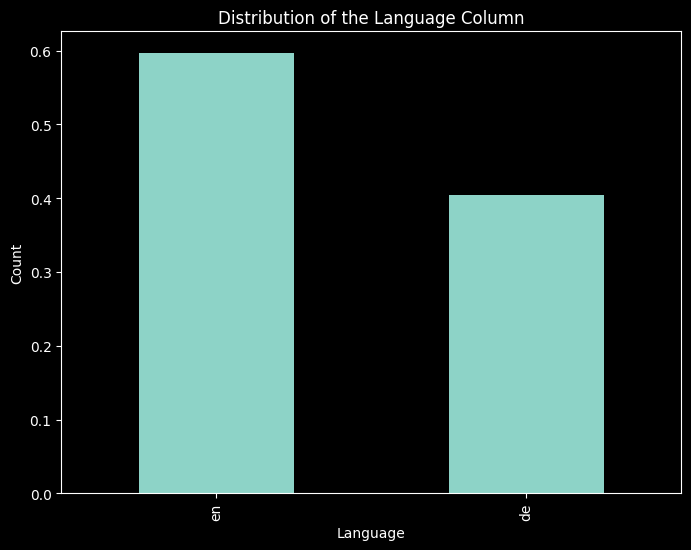

In [7]:
# Distribution of the 'language' column
plt.figure(figsize=(8, 6))
df['language'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of the Language Column')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

There are two languages: english and german. Now we check the distribution of tickets for each `type` category.

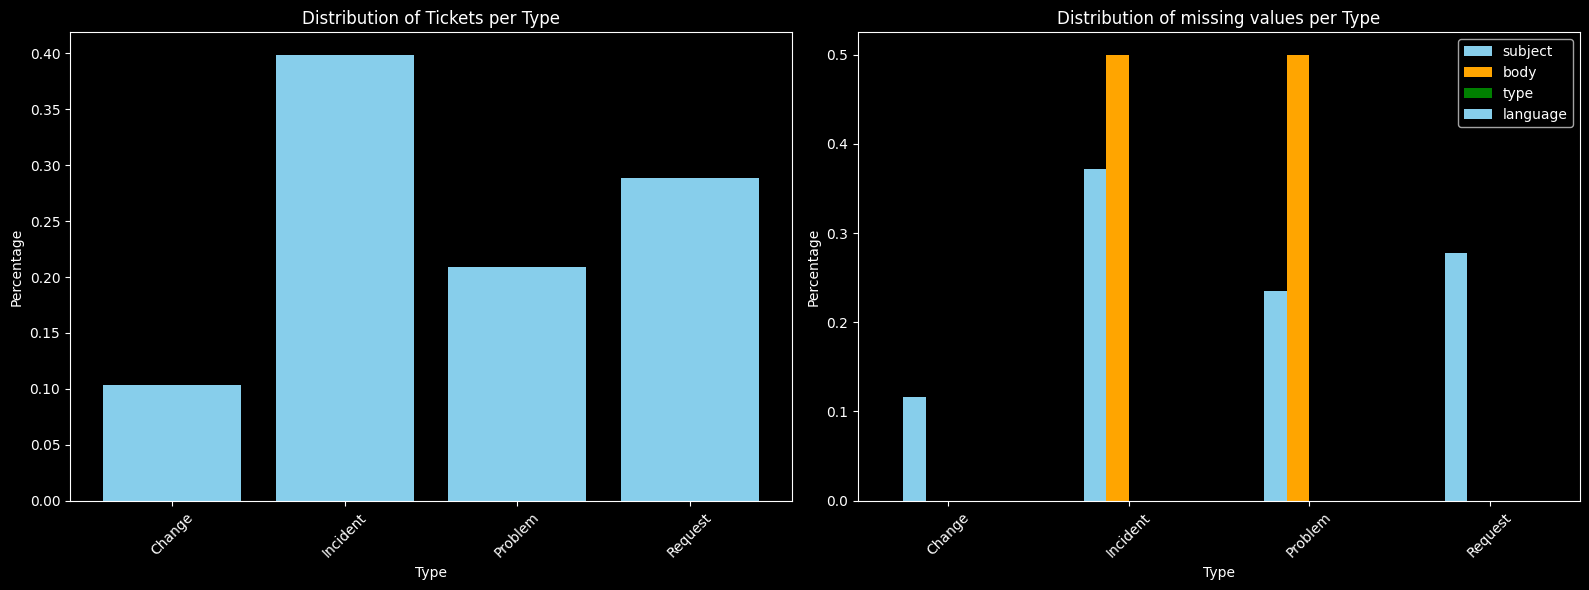

In [8]:

# Check the distribution of tickets for each `type` category.
type_counts = df['type'].value_counts()
# Normalize the counts
type_counts = type_counts / type_counts.sum()
# Sort the type_counts lexicographically
type_counts = type_counts.sort_index()


# Count for each type the number of rows with missing values
missing_values = df.groupby('type').apply(lambda x: x.isnull().sum())
# Normalize the counts
missing_values = missing_values / missing_values.sum()
# Sort the missing_values lexicographically
missing_values = missing_values.sort_index()



# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot the distribution of tickets for each `type` category on the first subplot
axes[0].bar(type_counts.index, type_counts.values, color='skyblue')
axes[0].set_title('Distribution of Tickets per Type')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=45)
# Plot the missing values per type on the second subplot
missing_values.plot(kind='bar', color=['skyblue', 'orange', 'green'], ax=axes[1])
axes[1].set_title('Distribution of missing values per Type')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Percentage')
axes[1].tick_params(axis='x', rotation=45)
# Adjust layout 
plt.tight_layout()
plt.show()


As observed from the plots, it is reasonable to remove all rows with NULL values, as doing so would not significantly impact the dataset. The distribution of missing values is almost proportional to the distribution of tickets across each type, especially for less numerous types. 
At most we will remove 1461 + 2 rows, that means only 7% of the total data.

## **2. Preprocessing**

In [9]:
# remove rows with missing values
df = df.dropna()
print(f"Tickets remaining after removing rows with missing values: {df.shape[0]}")

Tickets remaining after removing rows with missing values: 18537


Also, from the plot above we can see that `type` is not equally distributed, this could lead to problem when training the model. The solution to this problem could rely on augmenting data or balance the number of classed amoung the subset of training and testing records choosen.

It is beneficial to allow the classifier to work with a single feature that represents the Customer IT Ticket support. To achieve this, we concatenate the text from the `subject` and `body` columns for each row to create the new feature: `ticket`.

In [10]:
df = df.copy()
df.loc[:, 'ticket'] = df['subject'] + ' ' + df['body']
df.drop(['subject', 'body'], axis=1, inplace=True)

In [11]:
df

,type,language,ticket
0,Incident,de,Unvorhergesehener Absturz der Datenanalyse-Pla...
1,Request,en,Customer Support Inquiry Seeking information o...
2,Request,en,Data Analytics for Investment I am contacting ...
3,Incident,de,Krankenhaus-Dienstleistung-Problem Ein Medien-...
4,Request,en,"Security Dear Customer Support, I am reaching ..."
...,...,...,...
19994,Change,en,Support for Marketing Enhancements Request for...
19995,Problem,en,Assistance Needed for IFTTT Docker Integration...
19996,Change,de,Bitten um Unterstützung bei der Integration Se...
19998,Incident,de,Hilfe bei digitalen Strategie-Problemen Die Qu...


To simplify model training, we perform text cleaning. Here are the techniques used:

- **Tokenization**: Splitting text into individual words or phrases.
- **Punctuation Removal**: Removing commas, periods, and other punctuation marks.
- **Lemmatization**: Reducing words to their base form (e.g., "running" to "run").
- **Stemming**: Reducing words to their root (e.g., "running" to "run").
- **Removing Numbers and Symbols**: Eliminating unnecessary digits or special characters.
- **Removing Irrelevant Words**: Excluding words that don't contribute to context like stop words.

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# from textblob import TextBlob
# import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simoneavellino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simoneavellino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simoneavellino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def clean_text(text, language='english'):
    # Initialize tools
    stemmer = SnowballStemmer(language)
    stop_words = set(stopwords.words(language))
    
    # Tokenization
    words = word_tokenize(text.lower())
    
    # Remove Punctuation
    words = [word for word in words if word.isalnum()]
    
    # Stemming
    words = [stemmer.stem(word) for word in words]
    
    # Removing Numbers and Symbols
    words = [word for word in words if not word.isdigit()]
    
    # Remove Stop Words (Irrelevant Words)
    words = [word for word in words if word not in stop_words]
    
    # Return the cleaned text as a string
    return ' '.join(words)

In [14]:
def clean_tickets(df, tickets_indices=None):
    """ Clean the tickets in the DataFrame. 
        This function change the 'ticket' column in the DataFrame by cleaning the text.

    Args:
        df (DataFrame): The DataFrame containing the tickets.
        tickets_indices (list[int], Null): List of index of tickets. Defaults to None.

    """
    print(f"Cleaning tickets...", end='')
    if tickets_indices is None:
        tickets_indices = df.index
        
    for i in tickets_indices:
        language = df.loc[i, 'language']
        language = 'english' if language == 'en' else 'german'
        ticket = df.loc[i, 'ticket']
        df.loc[i, 'ticket'] = clean_text(ticket, language)
        
    print("Done.")

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(df, N, test_size=0.25, balanced=False, seed=42):
    """Split the data into training and testing sets so that 
    the training set contains N data points and the number of
    classes is balanced.

    Args:
        df (DataFrame): The DataFrame containing the data.
        N (int): Number of data points to select.
        test_size (float): The proportion of the dataset to include in the test split.
        balanced (bool): Whether to balance the classes or not.
        seed (int): Random seed for reproducibility.

    Returns:
        X_train: The training set tickets.
        X_test: The test set tickets.
        y_train: The training set ticket types.
        y_test: The test set ticket types.
    """
    np.random.seed(seed) 
    if balanced:
        # Split the data into classes
        df_classes = [df[df['type'] == i] for i in df['type'].unique()]
        n_distinct_classes = len(df_classes)
        n_elements_per_class = N // n_distinct_classes
        classes = []
        for class_ in df_classes:
            # If the class has less than n_elements_per_class samples, keep all the samples
            if class_.shape[0] < n_elements_per_class:
                classes.append(class_)
            else:
                classes.append(class_.sample(n=n_elements_per_class, random_state=seed))
                
        df_sampled = pd.concat(classes)
    else:
        df_sampled = df.sample(n=N, random_state=seed)
    
    clean_tickets(df_sampled)
    
    # Split the data into features and target
    X = df_sampled['ticket']
    y = df_sampled['type']
    
    # Split the data into training and testing sets 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    
    return X_train, X_test, y_train, y_test


## **3. String Kernel Implementation**

We will employ a Support Vector Machine (SVM) model utilizing a specialized kernel designed for textual data: the trigram kernel. This kernel operates by transforming the text into a feature space based on contiguous sequences of three characters (trigrams).

In [16]:
import functools

def extract_ngrams(text, n=3):
    """Extract n-grams from a text.

    Args:
        text (str): The input text.
        n (int): The size of the n-grams. Defaults to 3.

    Returns:
        list[str]: The n-grams extracted from the input text.
    """
    return [text[i:i+n] for i in range(len(text) - n + 1)]

def ngram_kernel(X, Y, n=3):
    """Compute the n-gram kernel between two lists of strings.

    Args:
        X (list[str]): List of strings.
        Y (list[str]): List of strings.
        n (int): The size of the n-grams. Defaults to 3.

    Returns:
        list[list[int]]: The kernel matrix between the two lists of strings.
    """
    # Extract n-grams from the input lists of strings
    ngrams_X = [extract_ngrams(text, n) for text in X]
    ngrams_Y = [extract_ngrams(text, n) for text in Y]
    
    # Get the set of all n-grams
    all_ngrams = set([ng for text in ngrams_X + ngrams_Y for ng in text])
    
    # Create the binary representation of the n-grams
    X_bin = np.array([[1 if ng in text else 0 for ng in all_ngrams] for text in ngrams_X])
    Y_bin = np.array([[1 if ng in text else 0 for ng in all_ngrams] for text in ngrams_Y])
    
    # Compute the kernel matrix
    return np.dot(X_bin, Y_bin.T)

def get_ngram_kernel(n=3):
    kernel = lambda X, Y: ngram_kernel(X, Y, n)
    return kernel


## **4. SVM Training**

The column `type` is made up with strings representing each ticket category. Let's convert all in numbers.

In [17]:
# convert the type columnn in a numerical format
df['type'] = pd.Categorical(df['type'])

# create a dictionary to map the type to a numerical value
type_mapping = {type_: i for i, type_ in enumerate(df['type'].cat.categories)}
# update the type column with the numerical values
df['type'] = df['type'].map(type_mapping)  
# invert type_mapping to map the numerical values back to the original type
type_mapping = {v: k for k, v in type_mapping.items()}

df

,type,language,ticket
0,1,de,Unvorhergesehener Absturz der Datenanalyse-Pla...
1,3,en,Customer Support Inquiry Seeking information o...
2,3,en,Data Analytics for Investment I am contacting ...
3,1,de,Krankenhaus-Dienstleistung-Problem Ein Medien-...
4,3,en,"Security Dear Customer Support, I am reaching ..."
...,...,...,...
19994,0,en,Support for Marketing Enhancements Request for...
19995,2,en,Assistance Needed for IFTTT Docker Integration...
19996,0,de,Bitten um Unterstützung bei der Integration Se...
19998,1,de,Hilfe bei digitalen Strategie-Problemen Die Qu...


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

def train_svm(X_train, y_train, kernel = get_ngram_kernel(3), C=0.01, param_grid=None):
    """Train an SVM model using a n-gram kernel (n=3 by default).

    Args:
        X_train: The training set tickets.
        y_train: The training set ticket types.

    Returns:
        svm: The trained SVM model.
    """
    if param_grid is not None:
        # Perform a grid search to find the best parameters
        print(f"Performing a grid search with the following parameters: {param_grid}, on {len(X_train)} samples...", end='')
        grid_search = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        print(" Done.")
        print(f"Best parameters: {grid_search.best_params_}")
        svm = grid_search.best_estimator_
    else:
        print(f"Training the SVM model on {len(X_train)} samples...", end='')
        svm = SVC(kernel=kernel, decision_function_shape='ovr', C=C, random_state=seed)
        svm.fit(X_train, y_train)
        print(" Done.")
    return svm

def evaluate_svm(svm, X, y):
    """Evaluate an SVM model.

    Args:
        svm: The trained SVM model.
        X_test: The test set tickets.
        y_test: The test set ticket types.
    """
    print(f"Evaluating the SVM model on {len(X)} samples...", end='')
    # save predictions
    predictions = svm.predict(X)
    print(" Done.")
    # print accuracy and f1-score
    print(f"Accuracy: {accuracy_score(y, predictions):.2f}")
    print(f"F1-Score: {f1_score(y, predictions, average='weighted'):.2f}")
    return predictions

In [19]:
def train_test_on_N_samples(df, N, kernel = get_ngram_kernel(3), C=0.01, param_grid=None):
    """Train and evaluate an SVM model on N samples.

    Args:
        df (DataFrame): The DataFrame containing the data.
        N (int): Number of data points to select.
        
    Returns:
        svm (SVC): The trained SVM model.
        X_test : The test set tickets.
        y_test: The test set ticket types.
        predictions: The predictions made by the SVM model.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(df, N, balanced=True)
    # Train the SVM model
    svm = train_svm(X_train, y_train, kernel=kernel, C=C, param_grid=param_grid)
    print("Evaluate on training set:")
    evaluate_svm(svm, X_train, y_train)
    print("Evaluate on test set:")
    predictions = evaluate_svm(svm, X_test, y_test)
    
    return svm, X_test, y_test, predictions

It's time to test our model. We will start by using a trigrams kernel and setting the regularization parameter C to 0.1.

In [20]:
_ = train_test_on_N_samples(df, N=1000, C = 0.1, kernel=get_ngram_kernel(3))

Cleaning tickets...Done.
Training the SVM model on 750 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 750 samples... Done.
Accuracy: 1.00
F1-Score: 1.00
Evaluate on test set:
Evaluating the SVM model on 250 samples... Done.
Accuracy: 0.69
F1-Score: 0.69


This model performs very well on the training set but not on the testing set, which suggests overfitting. To try to reduce overfitting, we will decrease the regularization parameter C to 0.01.

In [21]:
_ =train_test_on_N_samples(df, N=1000, C = 0.01, kernel=get_ngram_kernel(3))

Cleaning tickets...Done.
Training the SVM model on 750 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 750 samples...

KeyboardInterrupt: 

The situation does not change much, but it looks like there is less overfitting. Let's adjust the regularization parameter C one more time and set it to 0.005.

In [ ]:
_ =train_test_on_N_samples(df, N=1000, C = 0.005, kernel=get_ngram_kernel(3))

Cleaning tickets...Done.
Training the SVM model on 750 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 750 samples... Done.
Accuracy: 0.92
F1-Score: 0.92
Evaluate on test set:
Evaluating the SVM model on 250 samples... Done.
Accuracy: 0.72
F1-Score: 0.71


Now the model looks more balanced. Another thing to test is changing the n-gram kernel. Let's try using a 4-gram kernel.

In [ ]:
_ = train_test_on_N_samples(df, N=1000, C = 0.005, kernel=get_ngram_kernel(4))

Cleaning tickets...Done.
Training the SVM model on 750 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 750 samples... Done.
Accuracy: 0.95
F1-Score: 0.95
Evaluate on test set:
Evaluating the SVM model on 250 samples... Done.
Accuracy: 0.72
F1-Score: 0.72


Now we will use C = 0.005 and both 3-gram and 4-gram kernels to train the model on different values of N. This will help us evaluate the model's performance with different n-gram configurations.

In [ ]:
import time

Ns = [1000, 2000, 4000]
n_gram = [3, 4]

results = []

for n in n_gram:
    for N in Ns:
        print(f"\nTraining and evaluating the SVM ({n}-gram) model on {N} samples:")
        start_time = time.time()
        svm, X_test, y_test, predictions = train_test_on_N_samples(df, N=N, C=0.005, kernel=get_ngram_kernel(n))
        end_time = time.time()
        results.append({
            'clf': svm,
            'N': N,
            'n_gram': n,
            'X_test': X_test,
            'y_test': y_test,
            'predictions': predictions,
            'accuracy': np.round(accuracy_score(y_test, predictions), 2),
            'f1': np.round(f1_score(y_test, predictions, average='weighted'), 2),
            'time': np.round(end_time - start_time, 2)
        })
        print("-" * 50)

df_stats = pd.DataFrame(results)



Training and evaluating the SVM (3-gram) model on 1000 samples:
Cleaning tickets...Done.
Training the SVM model on 750 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 750 samples... Done.
Accuracy: 0.92
F1-Score: 0.92
Evaluate on test set:
Evaluating the SVM model on 250 samples... Done.
Accuracy: 0.72
F1-Score: 0.71
--------------------------------------------------

Training and evaluating the SVM (3-gram) model on 2000 samples:
Cleaning tickets...Done.
Training the SVM model on 1500 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 1500 samples... Done.
Accuracy: 0.89
F1-Score: 0.89
Evaluate on test set:
Evaluating the SVM model on 500 samples... Done.
Accuracy: 0.73
F1-Score: 0.72
--------------------------------------------------

Training and evaluating the SVM (3-gram) model on 4000 samples:
Cleaning tickets...Done.
Training the SVM model on 3000 samples... Done.
Evaluate on training set:
Evaluating the SVM model on 3000 samples... Do

In [ ]:
df_stats

,clf,N,n_gram,X_test,y_test,predictions,accuracy,f1,time
0,"SVC(C=0.005,\n kernel=<function get_ngram_k...",1000,3,4767 haufig verbindungsoptimier verschied ...,4767 2 7022 2 14433 2 16011 2 14...,"[1, 2, 1, 1, 3, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, ...",0.72,0.71,32.56
1,"SVC(C=0.005,\n kernel=<function get_ngram_k...",2000,3,3504 secur medic inform enhanc system i...,3504 0 4756 1 18640 2 15262 3 10...,"[3, 2, 2, 3, 2, 2, 3, 0, 1, 2, 2, 1, 2, 3, 2, ...",0.73,0.72,78.33
2,"SVC(C=0.005,\n kernel=<function get_ngram_k...",4000,3,13503 issu video lag dure virtual meet fina...,13503 1 6461 0 161 1 5674 0 15...,"[1, 0, 1, 0, 2, 2, 3, 2, 1, 2, 0, 0, 3, 3, 0, ...",0.75,0.75,195.28
3,"SVC(C=0.005,\n kernel=<function get_ngram_k...",1000,4,4767 haufig verbindungsoptimier verschied ...,4767 2 7022 2 14433 2 16011 2 14...,"[1, 1, 1, 1, 3, 2, 2, 0, 0, 2, 0, 2, 1, 0, 0, ...",0.72,0.72,103.22
4,"SVC(C=0.005,\n kernel=<function get_ngram_k...",2000,4,3504 secur medic inform enhanc system i...,3504 0 4756 1 18640 2 15262 3 10...,"[0, 2, 2, 3, 2, 2, 3, 0, 1, 2, 1, 1, 2, 3, 2, ...",0.76,0.76,268.60
5,"SVC(C=0.005,\n kernel=<function get_ngram_k...",4000,4,13503 issu video lag dure virtual meet fina...,13503 1 6461 0 161 1 5674 0 15...,"[2, 0, 1, 0, 2, 2, 3, 2, 1, 2, 0, 0, 3, 3, 0, ...",0.74,0.74,713.73


This manual approach could be replaced with a grid search method to explore different n-gram values on a larger sample. However, due to the significant time required for such an exhaustive search, we opted for this approach instead.

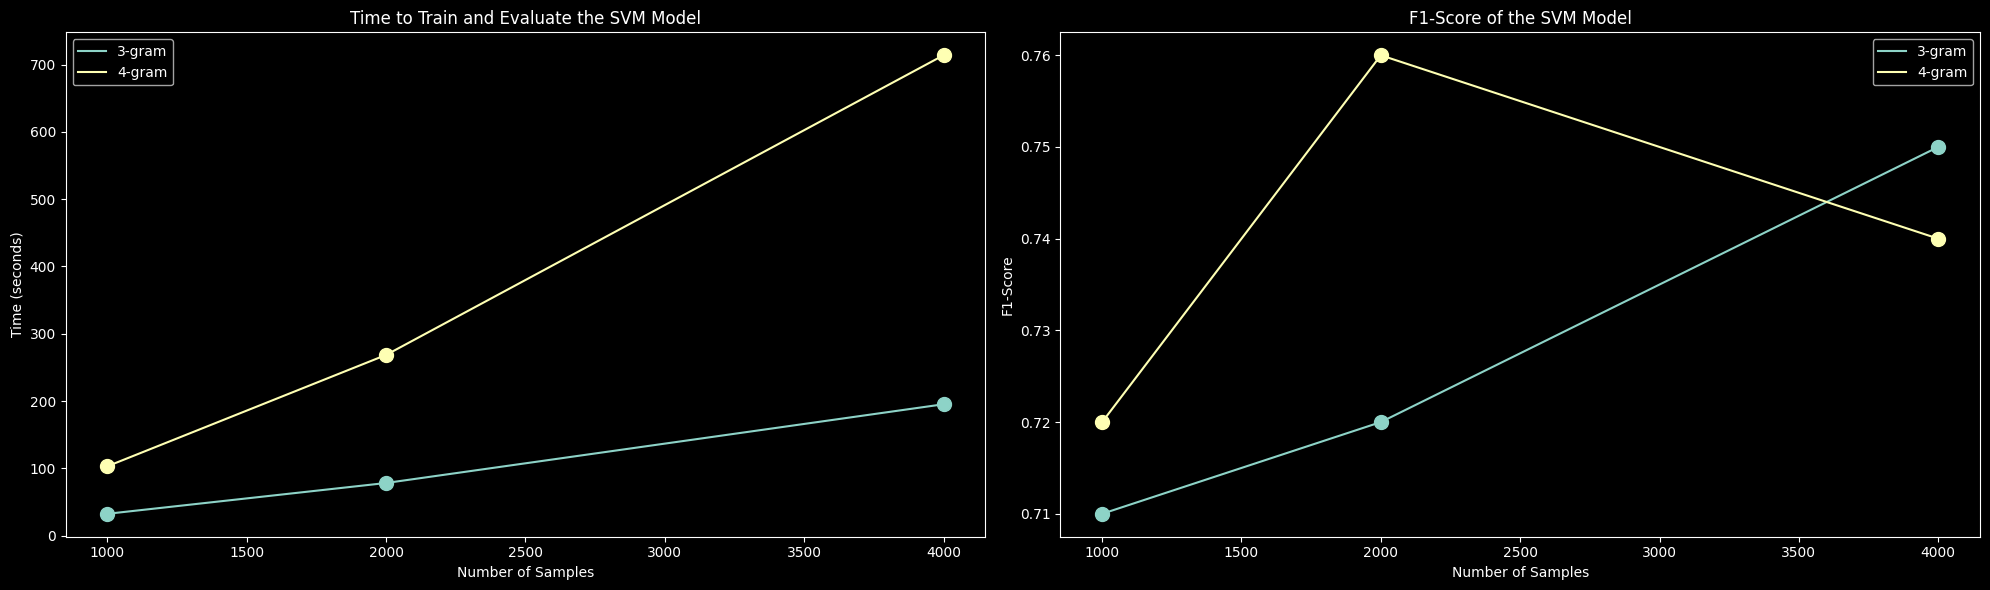

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# plot the time for each n-gram
for n in n_gram:
    df_n = df_stats[df_stats['n_gram'] == n]
    ax1.plot(df_n['N'], df_n['time'], label=f"{n}-gram")
    ax1.scatter(df_n['N'], df_n['time'], s=100)
ax1.set_title('Time to Train and Evaluate the SVM Model')
ax1.set_xlabel('Number of Samples')
ax1.set_ylabel('Time (seconds)')
ax1.legend()

# plot the f1-score for each n-gram
for n in n_gram:
    df_n = df_stats[df_stats['n_gram'] == n]
    ax2.plot(df_n['N'], df_n['f1'], label=f"{n}-gram")
    ax2.scatter(df_n['N'], df_n['f1'], s=100)
ax2.set_title('F1-Score of the SVM Model')
ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('F1-Score')
ax2.legend()

plt.tight_layout()
plt.show()


As can be seen, increasing the value of the n-gram significantly increases the time consumption. From the plot above, it seems that the best choice is the 4-gram model. 

It would be interesting to try n-grams greater than 4 to see if the trend of the F1 curve continues to decrease or improves. This could provide further insights into the optimal n-gram size for our model.

## **5. Model Evaluation and Analysis**

The model performs reasonably well, as observed. Next, we analyze the most common errors to understand the model's limitations.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, type_mapping, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plot a confusion matrix with proper class labels."""
    
    # Convert numerical labels to string labels using type_mapping
    class_labels = [type_mapping[i] for i in sorted(type_mapping.keys())]  
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('int')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set the correct labels on axes
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45, ha="right")
    plt.yticks(tick_marks, class_labels)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Annotate the matrix with values
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.show()


def hist_lenght_missclassified_tickets(df, y_test, predictions):
    """ 
    Plot the distribution of the lengths of the correct and misclassified tickets in two quadrants.
    """
    correct_predictions = np.where(y_test == predictions)[0]
    missclassified_indices = np.where(y_test != predictions)[0]
    
    # Compute ticket lengths without modifying the original DataFrame
    ticket_lengths = df.loc[y_test.index]['ticket'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    
    correct_lengths = ticket_lengths.iloc[correct_predictions]
    misclassified_lengths = ticket_lengths.iloc[missclassified_indices]
    
    # Create a figure with two subplots (quadrants)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # First plot: Histogram
    sns.histplot(correct_lengths, bins=30, kde=True, color='green', label="Correct Predictions", alpha=0.7, stat='density', ax=axes[0])
    sns.histplot(misclassified_lengths, bins=30, kde=True, color='red', label="Misclassified", alpha=0.7, stat='density', ax=axes[0])
    axes[0].set_title("Correct vs. Misclassified Ticket Lengths (Histogram)")
    axes[0].set_xlabel("Ticket Length (Words)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Second plot: CDF
    sns.ecdfplot(correct_lengths, color='green', label="Correct Predictions", ax=axes[1])
    sns.ecdfplot(misclassified_lengths, color='red', label="Misclassified", ax=axes[1])
    axes[1].set_title("Correct vs. Misclassified Ticket Lengths (CDF)")
    axes[1].set_xlabel("Ticket Length (Words)")
    axes[1].set_ylabel("CDF")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    

def print_missclassified_tickets_stats(df, X, y, y_pred, n=5):

    missclassified_indices = np.where(y.values != y_pred)[0]
    missclassified_indices_index = y.index[missclassified_indices]
    _df = df.loc[missclassified_indices_index]
    # add the predictions to the DataFrame
    _df['predicted'] = y_pred[missclassified_indices]
    
    languages = _df['language'].unique()
    
    for lan in languages:
        missclassified_group_by_lang = _df[_df['language'] == lan]
        print(f"Language: '{lan}'. Number of missclassified tickets: {missclassified_group_by_lang.shape[0]}. Percentage of missclassified tickets: {missclassified_group_by_lang.shape[0] / len(missclassified_indices) * 100:.2f}%\n")        
        # print(missclassified_group_by_lang)
        for i in missclassified_group_by_lang.index[:n]:
            ticket = missclassified_group_by_lang.loc[i]['ticket']
            print(f"Ticket #{i}: {ticket[:100]}...")
            true_label = type_mapping[missclassified_group_by_lang.loc[i]['type']]
            predicted_label = type_mapping[missclassified_group_by_lang.loc[i]['predicted']]
            print(colored(f"True Label: {true_label}", 'green'), ", ", colored(f"Predicted Label: {predicted_label}", 'red'))
        print("-" * 50)
        
    # Plot distribution of misclassified tickets per language
    plt.figure(figsize=(8, 6))
    _df['language'].value_counts(normalize=True).plot(kind='bar')
    plt.title('Distribution of Misclassified Tickets per Language')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.show()


We will analyze the model with the best F1 score to understand its performance and characteristics. This analysis will help us identify the strengths and weaknesses of the model and guide further improvements.

In [ ]:
# Get the best model 
best_model = df_stats.loc[df_stats['f1'].idxmax()]


X = best_model['X_test']
y = best_model['y_test']
y_pred = best_model['predictions']
clf = best_model['clf']
n_gram = best_model['n_gram']
N_samples = best_model['N']

print(f"Best model:\n   |Training| = {best_model['N'] * 0.75}\n   Uses a {n_gram}-gram kernel\n   C = {clf.C}")

Best model:
   |Training| = 1500.0
   Uses a 4-gram kernel
   C = 0.005


Language: 'de'. Number of missclassified tickets: 54. Percentage of missclassified tickets: 44.63%

Ticket #4756: Fachliche Unterstützung für Abrechnungsunterschiede bei SaaS-Dienstleistung erforderlich Es ist eine...
True Label: Incident ,  Predicted Label: Problem
Ticket #11532: Beten Sie um Unterstützung bei einem Datenverlust Sehr geehrte Kundenservice-Abteilung,\n\nich möcht...
True Label: Problem ,  Predicted Label: Incident
Ticket #13747: Fehler bei der Projektanlage - Unterstützung gesucht Ich stelle während der Projektanlage unerwartet...
True Label: Incident ,  Predicted Label: Problem
Ticket #18711: Login Failed Unexpectedly I am writing to report an issue I experienced with logging in this morning...
True Label: Incident ,  Predicted Label: Problem
Ticket #16695: Optimierung des Kundensupports Bewertete E-Mail zum Optimieren unseres Kundensupports und der digita...
True Label: Change ,  Predicted Label: Request
Ticket #5807: Medizinische Dateneingabe Ausfall Sehr geehrte Ku

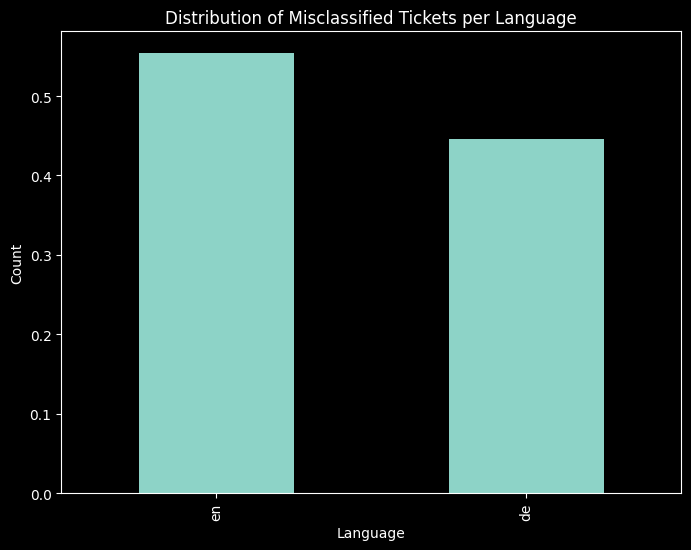

In [ ]:
print_missclassified_tickets_stats(df, X, y, y_pred, n=10)

In [ ]:
# print tickets with wrong language
df.loc[18711]

type                                                        1
language                                                   de
ticket      Login Failed Unexpectedly I am writing to repo...
Name: 18711, dtype: object

As evident from the statistics above, we could suppose that some tickets are mislabeled in terms of language. For instance, ticket #18711 is labeled as German, but the content is in English.

This mislabeling could impact the preprocessing of the tickets using NLTK, introducing noise into the data. For example, incorrect language detection may cause stop words to remain in the text, potentially affecting the classifier's performance.

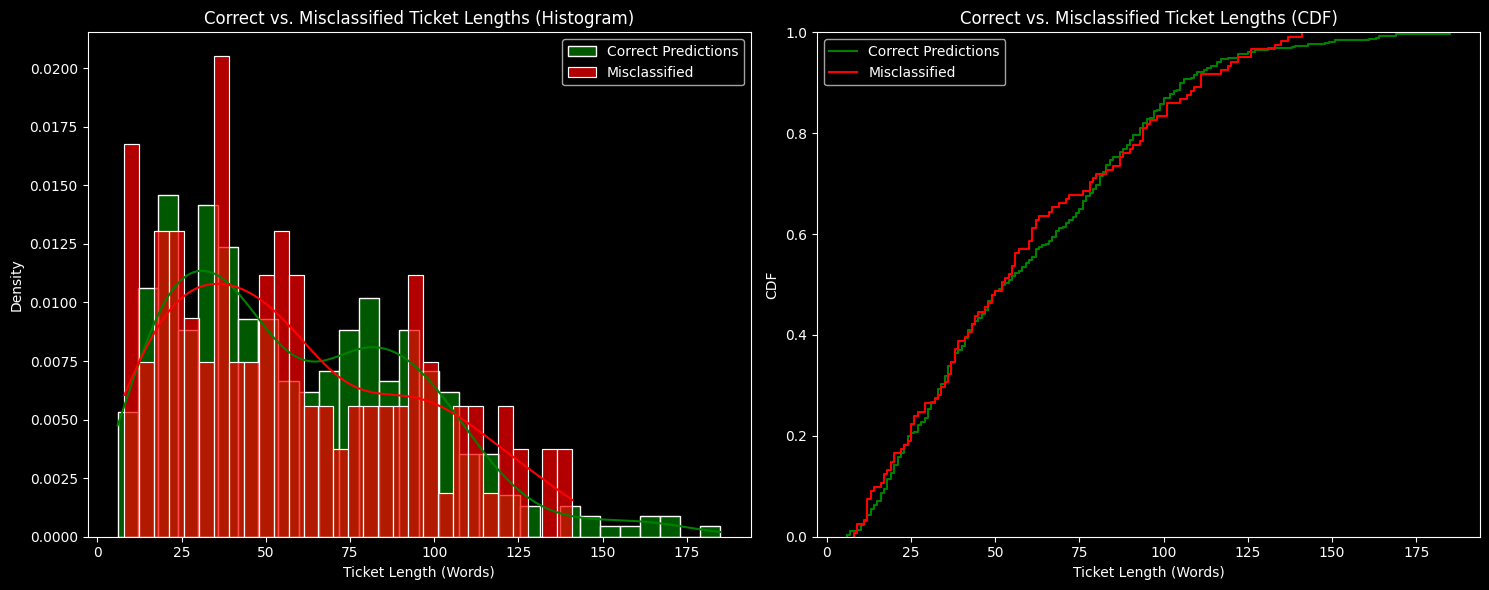

In [ ]:
hist_lenght_missclassified_tickets(df, y, y_pred)

As observed in the plots above, longer tickets tend to be misclassified. However, there does not appear to be a clear correlation between ticket length and misclassification.

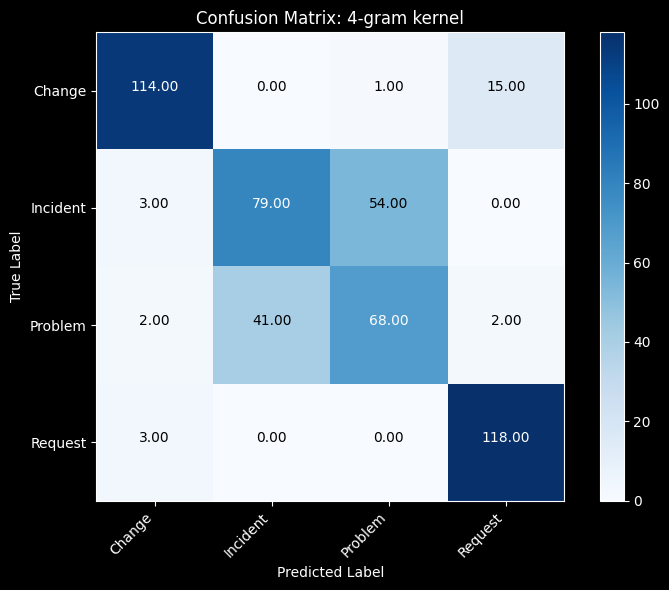

In [ ]:
plot_confusion_matrix(y, y_pred, title=f'Confusion Matrix: {n_gram}-gram kernel', type_mapping=type_mapping)

The most misclassified label appears to be 'problem,' often confused with 'incident' and viceversa. This suggests that these two types of tickets may share many similarities. To better understand how the categories are distributed in the feature space, we can apply Kernel PCA (KPCA) to visualize their separability.

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_kpca(X_kpca, y, type_mapping, title='Kernel PCA'):
    
    unique_labels = sorted(set(y))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels))) 
    label_to_color = {label: mcolors.to_hex(color) for label, color in zip(unique_labels, colors)}
    y_colors = np.array([label_to_color[label] for label in y])
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=8, label=type_mapping[label]) for label in unique_labels]

    # 2D Plot
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y_colors, alpha=0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(handles=patches, title="Ticket Type")
    plt.show()

    # 3D Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=X_kpca[:, 0],
        y=X_kpca[:, 1],
        z=X_kpca[:, 2],
        mode='markers',
        marker=dict(
            size=6,
            color=y_colors,
            opacity=0.8
        ),
        text=[type_mapping[label] for label in y],
        hoverinfo='text'
    ))

    fig.update_layout(
        template='plotly_dark',
        title=title,
        scene=dict(
            xaxis_title="Component 1",
            yaxis_title="Component 2",
            zaxis_title="Component 3"
        )
    )

    fig.show()


In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=3, kernel='precomputed')

In [ ]:
K_3ngram = get_ngram_kernel(3)(X, X)
X_kpca_3ngram = kpca.fit_transform(K_3ngram)

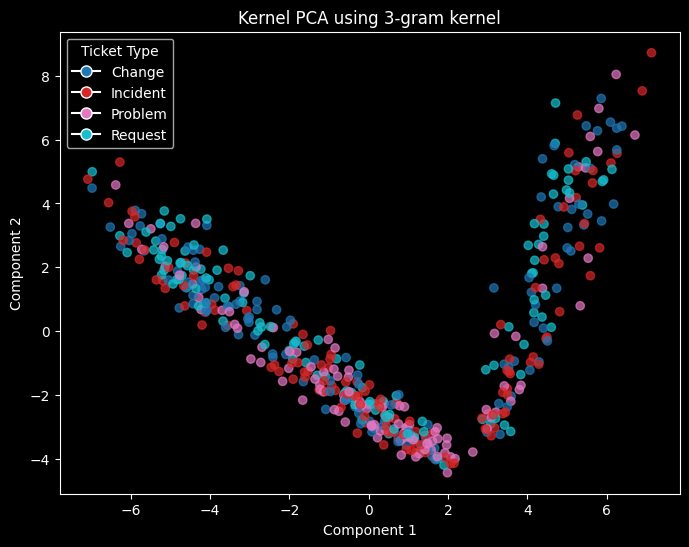

In [ ]:
plot_kpca(X_kpca_3ngram, y, title='Kernel PCA using 3-gram kernel', type_mapping=type_mapping)

Using a 3-gram kernel, we observe that points corresponding to the 'Incident' and 'Problem' classes are not well separated. This lack of distinction may explain why the model struggles to effectively differentiate between the two categories. Let's try to increase the n-gram size.

In [ ]:
K_4ngram = get_ngram_kernel(4)(X, X)
X_kpca_4ngram = kpca.fit_transform(K_4ngram)

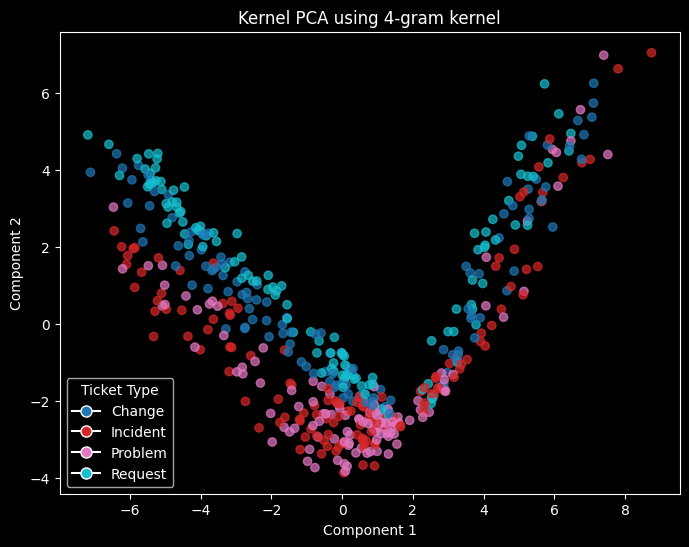

In [ ]:
plot_kpca(X_kpca_4ngram, y, title='Kernel PCA using 4-gram kernel', type_mapping=type_mapping)

Using a 4-gram kernel, the separation between the classes 'Problem', 'Incident', 'Request', and 'Change' improves. However, distinguishing between 'Problem' and 'Incident' remains challenging. Let's test one last time to increase the n-gram size to 5.

In [ ]:
K_5ngram = get_ngram_kernel(5)(X, X)
X_kpca_5ngram = kpca.fit_transform(K_5ngram)

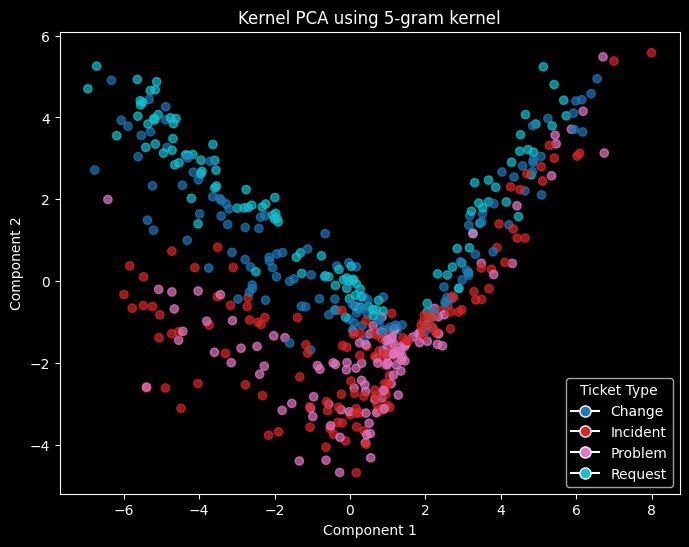

In [ ]:
plot_kpca(X_kpca_5ngram, y, title='Kernel PCA using 5-gram kernel', type_mapping=type_mapping)

The results have improved, but distinguishing between 'Problem' and 'Incident' remains challenging. We could consider using a different model to enhance classification performance.

In this implementation, the **One-Vs-All (OVA)** strategy was chosen for handling the multiclass classification problem using SVM. 

The **OVA approach** trains multiple binary classifiers, where each classifier distinguishes one class from all the others. This method was selected for several reasons:

1. **Semplicity** – This approch is lighter than **One-vs-One** as it trains less classifiers.

2. **Better suited for unbalanced data** – When class distributions are imbalanced, OVR can be more stable than OVO, as it ensures that each class has sufficient positive and negative samples for training.

Despite these advantages, **OVA may struggle when classes overlap significantly**, as is the case with 'Problem' and 'Incident' in our dataset.


## **6. Use of another model**

Let's try to use decision trees to perform the same task. We start by using the same amount of point used for the training of the best model.

In [ ]:
N_samples

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time

# Transform the text data using TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train, X_test, y_train, y_test = split_data(df, N=N_samples, test_size=0.25, balanced=True, seed=seed)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

clf_tree = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(clf_tree, param_grid, cv=5)
start = time.time()
print("Start training the Decision Tree model using grid search...", end='')
grid_search_tree.fit(X_train, y_train)
time_tree = time.time() - start
print("Done in", np.round(time_tree, 2), "seconds.")

Cleaning tickets...Done.
Start training the Decision Tree model using grid search...Done in 9.42 seconds.


In [ ]:
print("Best parameters found by grid search:")
print(grid_search_tree.best_params_)

Best parameters found by grid search:
{'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# test
y_pred_tree = grid_search_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree, average='weighted'):.2f}")

Accuracy: 0.61
F1-Score: 0.61


The Decision Tree model is significantly faster to train on the same amount of data. We also used grid search, but the results are not as strong as those from the SVM. Perhaps a more powerful model, such as LLMs, could provide better performance. However, given the computational requirements, my computer might not handle it well. For now, we will try to fit the decision tree model using the entire dataset.


In [ ]:
X_train, X_test, y_train, y_test = split_data(df, N=len(df), test_size=0.25, balanced=True, seed=seed)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

clf_tree = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_tree = GridSearchCV(clf_tree, param_grid, cv=5)
start = time.time()
print("Start training the Decision Tree model using grid search...", end='')
grid_search_tree.fit(X_train, y_train)
time_tree = time.time() - start
print("Done in", np.round(time_tree, 2), "seconds.")

Cleaning tickets...Done.
Start training the Decision Tree model using grid search...Done in 127.35 seconds.


In [ ]:
print("Best parameters found by grid search:")
print(grid_search_tree.best_params_)

Best parameters found by grid search:
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# test
y_pred_tree = grid_search_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree, average='weighted'):.2f}")

Accuracy: 0.68
F1-Score: 0.68


One advantage of the Decision Tree model is its speed in both training and testing. This makes the Decision Tree a more efficient choice in terms of time, especially with larger datasets. But for this task they are not the best choice.